In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [3]:
data_df = pd.read_csv('../../../_data/Kr2010.csv', index_col=0)

min_rt = data_df.groupby(by='sbj')['rt'].min()

tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(data_df[['rt', 'Right']])
X_train = np.asarray(data_df[['item_value_1', 'item_value_2', 'gaze_1', 'gaze_2']])

obs_test = np.asarray(data_df[['rt', 'Right']])
X_test = np.asarray(data_df[['item_value_1', 'item_value_2', 'gaze_1', 'gaze_2']])

print(X_train.shape, X_test.shape)

(3522, 4) (3522, 4)


In [4]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
    ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    scl = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-3][i-1])) for i in tr_df['sbj']])
    
    ll1 = (1 - obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2), axis=-1)

In [5]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [6]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = data_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 129       
                                                                 
Total params: 422 (1.65 KB)
Trainable params: 422 (1.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [7]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=4000)

Epoch 1/4000
1/1 [==============================] - 92s 92s/step - loss: 21466.4492
Epoch 2/4000
1/1 [==============================] - 0s 31ms/step - loss: 21361.3789
Epoch 3/4000
1/1 [==============================] - 0s 22ms/step - loss: 21286.2324
Epoch 4/4000
1/1 [==============================] - 0s 23ms/step - loss: 21223.0156
Epoch 5/4000
1/1 [==============================] - 0s 22ms/step - loss: 21166.5918
Epoch 6/4000
1/1 [==============================] - 0s 22ms/step - loss: 21114.7188
Epoch 7/4000
1/1 [==============================] - 0s 22ms/step - loss: 21066.1660
Epoch 8/4000
1/1 [==============================] - 0s 21ms/step - loss: 21020.1504
Epoch 9/4000
1/1 [==============================] - 0s 22ms/step - loss: 20976.1309
Epoch 10/4000
1/1 [==============================] - 0s 22ms/step - loss: 20933.7227
Epoch 11/4000
1/1 [==============================] - 0s 21ms/step - loss: 20892.6387
Epoch 12/4000
1/1 [==============================] - 0s 23ms/step - loss: 

1/1 [==============================] - 0s 33ms/step - loss: 17307.2500
Epoch 193/4000
1/1 [==============================] - 0s 35ms/step - loss: 17296.1445
Epoch 194/4000
1/1 [==============================] - 0s 35ms/step - loss: 17285.0859
Epoch 195/4000
1/1 [==============================] - 0s 34ms/step - loss: 17274.0703
Epoch 196/4000
1/1 [==============================] - 0s 35ms/step - loss: 17263.0977
Epoch 197/4000
1/1 [==============================] - 0s 35ms/step - loss: 17252.1699
Epoch 198/4000
1/1 [==============================] - 0s 34ms/step - loss: 17241.2891
Epoch 199/4000
1/1 [==============================] - 0s 34ms/step - loss: 17230.4473
Epoch 200/4000
1/1 [==============================] - 0s 34ms/step - loss: 17219.6484
Epoch 201/4000
1/1 [==============================] - 0s 34ms/step - loss: 17208.8926
Epoch 202/4000
1/1 [==============================] - 0s 34ms/step - loss: 17198.1797
Epoch 203/4000
1/1 [==============================] - 0s 34ms/step - 

1/1 [==============================] - 0s 35ms/step - loss: 15700.8740
Epoch 383/4000
1/1 [==============================] - 0s 33ms/step - loss: 15693.8838
Epoch 384/4000
1/1 [==============================] - 0s 33ms/step - loss: 15686.8936
Epoch 385/4000
1/1 [==============================] - 0s 33ms/step - loss: 15679.9121
Epoch 386/4000
1/1 [==============================] - 0s 33ms/step - loss: 15672.9336
Epoch 387/4000
1/1 [==============================] - 0s 33ms/step - loss: 15665.9600
Epoch 388/4000
1/1 [==============================] - 0s 33ms/step - loss: 15658.9873
Epoch 389/4000
1/1 [==============================] - 0s 33ms/step - loss: 15652.0205
Epoch 390/4000
1/1 [==============================] - 0s 33ms/step - loss: 15645.0566
Epoch 391/4000
1/1 [==============================] - 0s 32ms/step - loss: 15638.0918
Epoch 392/4000
1/1 [==============================] - 0s 33ms/step - loss: 15631.1338
Epoch 393/4000
1/1 [==============================] - 0s 32ms/step - 

1/1 [==============================] - 0s 32ms/step - loss: 14130.9570
Epoch 573/4000
1/1 [==============================] - 0s 32ms/step - loss: 14122.7363
Epoch 574/4000
1/1 [==============================] - 0s 33ms/step - loss: 14114.5000
Epoch 575/4000
1/1 [==============================] - 0s 32ms/step - loss: 14106.2920
Epoch 576/4000
1/1 [==============================] - 0s 32ms/step - loss: 14098.0693
Epoch 577/4000
1/1 [==============================] - 0s 32ms/step - loss: 14089.8770
Epoch 578/4000
1/1 [==============================] - 0s 33ms/step - loss: 14081.6699
Epoch 579/4000
1/1 [==============================] - 0s 32ms/step - loss: 14073.4893
Epoch 580/4000
1/1 [==============================] - 0s 33ms/step - loss: 14065.2979
Epoch 581/4000
1/1 [==============================] - 0s 32ms/step - loss: 14057.1367
Epoch 582/4000
1/1 [==============================] - 0s 32ms/step - loss: 14048.9619
Epoch 583/4000
1/1 [==============================] - 0s 32ms/step - 

1/1 [==============================] - 0s 32ms/step - loss: 12651.1807
Epoch 763/4000
1/1 [==============================] - 0s 32ms/step - loss: 12643.7607
Epoch 764/4000
1/1 [==============================] - 0s 32ms/step - loss: 12636.2705
Epoch 765/4000
1/1 [==============================] - 0s 33ms/step - loss: 12628.8564
Epoch 766/4000
1/1 [==============================] - 0s 32ms/step - loss: 12621.3721
Epoch 767/4000
1/1 [==============================] - 0s 32ms/step - loss: 12613.9668
Epoch 768/4000
1/1 [==============================] - 0s 33ms/step - loss: 12606.4893
Epoch 769/4000
1/1 [==============================] - 0s 32ms/step - loss: 12599.0898
Epoch 770/4000
1/1 [==============================] - 0s 32ms/step - loss: 12591.6182
Epoch 771/4000
1/1 [==============================] - 0s 32ms/step - loss: 12584.2246
Epoch 772/4000
1/1 [==============================] - 0s 33ms/step - loss: 12576.7598
Epoch 773/4000
1/1 [==============================] - 0s 33ms/step - 

1/1 [==============================] - 0s 35ms/step - loss: 11318.9590
Epoch 953/4000
1/1 [==============================] - 0s 35ms/step - loss: 11312.8096
Epoch 954/4000
1/1 [==============================] - 0s 33ms/step - loss: 11306.5508
Epoch 955/4000
1/1 [==============================] - 0s 38ms/step - loss: 11300.4590
Epoch 956/4000
1/1 [==============================] - 0s 37ms/step - loss: 11294.2510
Epoch 957/4000
1/1 [==============================] - 0s 34ms/step - loss: 11288.2188
Epoch 958/4000
1/1 [==============================] - 0s 33ms/step - loss: 11282.0654
Epoch 959/4000
1/1 [==============================] - 0s 33ms/step - loss: 11276.0947
Epoch 960/4000
1/1 [==============================] - 0s 39ms/step - loss: 11270.0010
Epoch 961/4000
1/1 [==============================] - 0s 33ms/step - loss: 11264.0879
Epoch 962/4000
1/1 [==============================] - 0s 32ms/step - loss: 11258.0557
Epoch 963/4000
1/1 [==============================] - 0s 33ms/step - 

1/1 [==============================] - 0s 34ms/step - loss: 10496.6113
Epoch 1141/4000
1/1 [==============================] - 0s 34ms/step - loss: 10493.5762
Epoch 1142/4000
1/1 [==============================] - 0s 35ms/step - loss: 10490.4346
Epoch 1143/4000
1/1 [==============================] - 0s 34ms/step - loss: 10487.4209
Epoch 1144/4000
1/1 [==============================] - 0s 34ms/step - loss: 10484.3057
Epoch 1145/4000
1/1 [==============================] - 0s 40ms/step - loss: 10481.3145
Epoch 1146/4000
1/1 [==============================] - 0s 39ms/step - loss: 10478.2227
Epoch 1147/4000
1/1 [==============================] - 0s 36ms/step - loss: 10475.2500
Epoch 1148/4000
1/1 [==============================] - 0s 34ms/step - loss: 10472.1768
Epoch 1149/4000
1/1 [==============================] - 0s 32ms/step - loss: 10469.2305
Epoch 1150/4000
1/1 [==============================] - 0s 33ms/step - loss: 10466.1787
Epoch 1151/4000
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 30ms/step - loss: 10078.1699
Epoch 1329/4000
1/1 [==============================] - 0s 31ms/step - loss: 10076.6719
Epoch 1330/4000
1/1 [==============================] - 0s 32ms/step - loss: 10075.1475
Epoch 1331/4000
1/1 [==============================] - 0s 31ms/step - loss: 10073.6680
Epoch 1332/4000
1/1 [==============================] - 0s 31ms/step - loss: 10072.1553
Epoch 1333/4000
1/1 [==============================] - 0s 31ms/step - loss: 10070.6836
Epoch 1334/4000
1/1 [==============================] - 0s 32ms/step - loss: 10069.1982
Epoch 1335/4000
1/1 [==============================] - 0s 31ms/step - loss: 10067.7432
Epoch 1336/4000
1/1 [==============================] - 0s 32ms/step - loss: 10066.2451
Epoch 1337/4000
1/1 [==============================] - 0s 36ms/step - loss: 10064.8086
Epoch 1338/4000
1/1 [==============================] - 0s 39ms/step - loss: 10063.3242
Epoch 1339/4000
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 32ms/step - loss: 9868.2578
Epoch 1518/4000
1/1 [==============================] - 0s 33ms/step - loss: 9867.3945
Epoch 1519/4000
1/1 [==============================] - 0s 31ms/step - loss: 9866.6367
Epoch 1520/4000
1/1 [==============================] - 0s 31ms/step - loss: 9865.8340
Epoch 1521/4000
1/1 [==============================] - 0s 37ms/step - loss: 9865.0410
Epoch 1522/4000
1/1 [==============================] - 0s 34ms/step - loss: 9864.2676
Epoch 1523/4000
1/1 [==============================] - 0s 33ms/step - loss: 9863.5010
Epoch 1524/4000
1/1 [==============================] - 0s 32ms/step - loss: 9862.6035
Epoch 1525/4000
1/1 [==============================] - 0s 33ms/step - loss: 9861.7754
Epoch 1526/4000
1/1 [==============================] - 0s 33ms/step - loss: 9860.9668
Epoch 1527/4000
1/1 [==============================] - 0s 33ms/step - loss: 9860.2012
Epoch 1528/4000
1/1 [==============================] - 0s 36ms/step - 

1/1 [==============================] - 0s 33ms/step - loss: 9743.6113
Epoch 1708/4000
1/1 [==============================] - 0s 33ms/step - loss: 9744.0879
Epoch 1709/4000
1/1 [==============================] - 0s 32ms/step - loss: 9742.9727
Epoch 1710/4000
1/1 [==============================] - 0s 34ms/step - loss: 9742.7334
Epoch 1711/4000
1/1 [==============================] - 0s 32ms/step - loss: 9742.6475
Epoch 1712/4000
1/1 [==============================] - 0s 33ms/step - loss: 9741.2100
Epoch 1713/4000
1/1 [==============================] - 0s 34ms/step - loss: 9740.7168
Epoch 1714/4000
1/1 [==============================] - 0s 33ms/step - loss: 9740.6299
Epoch 1715/4000
1/1 [==============================] - 0s 32ms/step - loss: 9739.9883
Epoch 1716/4000
1/1 [==============================] - 0s 32ms/step - loss: 9740.0684
Epoch 1717/4000
1/1 [==============================] - 0s 33ms/step - loss: 9738.8125
Epoch 1718/4000
1/1 [==============================] - 0s 33ms/step - 

1/1 [==============================] - 0s 31ms/step - loss: 9659.8184
Epoch 1898/4000
1/1 [==============================] - 0s 31ms/step - loss: 9658.2188
Epoch 1899/4000
1/1 [==============================] - 0s 32ms/step - loss: 9657.4473
Epoch 1900/4000
1/1 [==============================] - 0s 31ms/step - loss: 9658.6289
Epoch 1901/4000
1/1 [==============================] - 0s 31ms/step - loss: 9657.3672
Epoch 1902/4000
1/1 [==============================] - 0s 32ms/step - loss: 9658.1934
Epoch 1903/4000
1/1 [==============================] - 0s 31ms/step - loss: 9658.2236
Epoch 1904/4000
1/1 [==============================] - 0s 31ms/step - loss: 9660.0225
Epoch 1905/4000
1/1 [==============================] - 0s 31ms/step - loss: 9662.8877
Epoch 1906/4000
1/1 [==============================] - 0s 31ms/step - loss: 9670.5811
Epoch 1907/4000
1/1 [==============================] - 0s 31ms/step - loss: 9674.5615
Epoch 1908/4000
1/1 [==============================] - 0s 31ms/step - 

1/1 [==============================] - 0s 32ms/step - loss: 9606.6416
Epoch 2089/4000
1/1 [==============================] - 0s 31ms/step - loss: 9605.1006
Epoch 2090/4000
1/1 [==============================] - 0s 31ms/step - loss: 9604.2764
Epoch 2091/4000
1/1 [==============================] - 0s 31ms/step - loss: 9608.3896
Epoch 2092/4000
1/1 [==============================] - 0s 31ms/step - loss: 9619.6885
Epoch 2093/4000
1/1 [==============================] - 0s 33ms/step - loss: 9607.0918
Epoch 2094/4000
1/1 [==============================] - 0s 32ms/step - loss: 9603.3359
Epoch 2095/4000
1/1 [==============================] - 0s 32ms/step - loss: 9600.1523
Epoch 2096/4000
1/1 [==============================] - 0s 32ms/step - loss: nan
Epoch 2097/4000
1/1 [==============================] - 0s 33ms/step - loss: 9607.1768
Epoch 2098/4000
1/1 [==============================] - 0s 32ms/step - loss: 9607.4814
Epoch 2099/4000
1/1 [==============================] - 0s 33ms/step - loss: 

Epoch 2279/4000
1/1 [==============================] - 0s 31ms/step - loss: 9567.6279
Epoch 2280/4000
1/1 [==============================] - 0s 31ms/step - loss: 9576.8594
Epoch 2281/4000
1/1 [==============================] - 0s 31ms/step - loss: nan
Epoch 2282/4000
1/1 [==============================] - 0s 31ms/step - loss: 9563.5879
Epoch 2283/4000
1/1 [==============================] - 0s 31ms/step - loss: 9562.6904
Epoch 2284/4000
1/1 [==============================] - 0s 31ms/step - loss: 9561.3496
Epoch 2285/4000
1/1 [==============================] - 0s 31ms/step - loss: nan
Epoch 2286/4000
1/1 [==============================] - 0s 31ms/step - loss: nan
Epoch 2287/4000
1/1 [==============================] - 0s 32ms/step - loss: 9559.2314
Epoch 2288/4000
1/1 [==============================] - 0s 31ms/step - loss: 9560.9189
Epoch 2289/4000
1/1 [==============================] - 0s 30ms/step - loss: 9556.4922
Epoch 2290/4000
1/1 [==============================] - 0s 31ms/step - lo

Epoch 2375/4000
1/1 [==============================] - 0s 32ms/step - loss: 9550.3252
Epoch 2376/4000
1/1 [==============================] - 0s 32ms/step - loss: nan
Epoch 2377/4000
1/1 [==============================] - 0s 33ms/step - loss: nan
Epoch 2378/4000
1/1 [==============================] - 0s 37ms/step - loss: 9546.8174
Epoch 2379/4000
1/1 [==============================] - 0s 33ms/step - loss: 9546.4521
Epoch 2380/4000
1/1 [==============================] - 0s 33ms/step - loss: 9547.8799
Epoch 2381/4000
1/1 [==============================] - 0s 34ms/step - loss: 9548.1768
Epoch 2382/4000
1/1 [==============================] - 0s 32ms/step - loss: 9545.0273
Epoch 2383/4000
1/1 [==============================] - 0s 32ms/step - loss: 9548.6533
Epoch 2384/4000
1/1 [==============================] - 0s 33ms/step - loss: 9547.8252
Epoch 2385/4000
1/1 [==============================] - 0s 32ms/step - loss: 9548.9785
Epoch 2386/4000
1/1 [==============================] - 0s 32ms/ste

1/1 [==============================] - 0s 30ms/step - loss: 9532.7412
Epoch 2472/4000
1/1 [==============================] - 0s 31ms/step - loss: 9533.4678
Epoch 2473/4000
1/1 [==============================] - 0s 31ms/step - loss: 9531.9678
Epoch 2474/4000
1/1 [==============================] - 0s 30ms/step - loss: 9535.6650
Epoch 2475/4000
1/1 [==============================] - 0s 31ms/step - loss: 9533.1094
Epoch 2476/4000
1/1 [==============================] - 0s 31ms/step - loss: 9536.0166
Epoch 2477/4000
1/1 [==============================] - 0s 30ms/step - loss: 9534.4697
Epoch 2478/4000
1/1 [==============================] - 0s 31ms/step - loss: nan
Epoch 2479/4000
1/1 [==============================] - 0s 31ms/step - loss: 9541.5986
Epoch 2480/4000
1/1 [==============================] - 0s 31ms/step - loss: 9540.3779
Epoch 2481/4000
1/1 [==============================] - 0s 31ms/step - loss: 9539.2705
Epoch 2482/4000
1/1 [==============================] - 0s 31ms/step - loss: 

Epoch 2567/4000
1/1 [==============================] - 0s 31ms/step - loss: 9520.4180
Epoch 2568/4000
1/1 [==============================] - 0s 31ms/step - loss: 9520.1006
Epoch 2569/4000
1/1 [==============================] - 0s 30ms/step - loss: 9519.8711
Epoch 2570/4000
1/1 [==============================] - 0s 30ms/step - loss: nan
Epoch 2571/4000
1/1 [==============================] - 0s 30ms/step - loss: 9520.1006
Epoch 2572/4000
1/1 [==============================] - 0s 30ms/step - loss: 9527.6318
Epoch 2573/4000
1/1 [==============================] - 0s 31ms/step - loss: 9530.8311
Epoch 2574/4000
1/1 [==============================] - 0s 32ms/step - loss: nan
Epoch 2575/4000
1/1 [==============================] - 0s 31ms/step - loss: 9526.5430
Epoch 2576/4000
1/1 [==============================] - 0s 31ms/step - loss: 9544.6328
Epoch 2577/4000
1/1 [==============================] - 0s 31ms/step - loss: 9522.2598
Epoch 2578/4000
1/1 [==============================] - 0s 31ms/ste

Epoch 2663/4000
1/1 [==============================] - 0s 31ms/step - loss: 9509.1377
Epoch 2664/4000
1/1 [==============================] - 0s 31ms/step - loss: 9510.3252
Epoch 2665/4000
1/1 [==============================] - 0s 35ms/step - loss: 9511.1787
Epoch 2666/4000
1/1 [==============================] - 0s 33ms/step - loss: 9508.1934
Epoch 2667/4000
1/1 [==============================] - 0s 31ms/step - loss: 9506.6396
Epoch 2668/4000
1/1 [==============================] - 0s 31ms/step - loss: 9509.1201
Epoch 2669/4000
1/1 [==============================] - 0s 30ms/step - loss: 9509.7773
Epoch 2670/4000
1/1 [==============================] - 0s 30ms/step - loss: 9517.8291
Epoch 2671/4000
1/1 [==============================] - 0s 31ms/step - loss: 9521.4893
Epoch 2672/4000
1/1 [==============================] - 0s 31ms/step - loss: 9519.9766
Epoch 2673/4000
1/1 [==============================] - 0s 30ms/step - loss: 9514.2188
Epoch 2674/4000
1/1 [==============================] -

1/1 [==============================] - 0s 34ms/step - loss: 9499.1055
Epoch 2854/4000
1/1 [==============================] - 0s 33ms/step - loss: 9492.8613
Epoch 2855/4000
1/1 [==============================] - 0s 32ms/step - loss: 9493.0029
Epoch 2856/4000
1/1 [==============================] - 0s 32ms/step - loss: 9492.8799
Epoch 2857/4000
1/1 [==============================] - 0s 32ms/step - loss: 9496.1777
Epoch 2858/4000
1/1 [==============================] - 0s 32ms/step - loss: 9492.6504
Epoch 2859/4000
1/1 [==============================] - 0s 32ms/step - loss: 9492.5635
Epoch 2860/4000
1/1 [==============================] - 0s 32ms/step - loss: 9490.2295
Epoch 2861/4000
1/1 [==============================] - 0s 32ms/step - loss: 9492.6543
Epoch 2862/4000
1/1 [==============================] - 0s 32ms/step - loss: 9492.2148
Epoch 2863/4000
1/1 [==============================] - 0s 33ms/step - loss: 9496.0107
Epoch 2864/4000
1/1 [==============================] - 0s 32ms/step - 

1/1 [==============================] - 0s 34ms/step - loss: 9484.9551
Epoch 3044/4000
1/1 [==============================] - 0s 32ms/step - loss: 9475.9072
Epoch 3045/4000
1/1 [==============================] - 0s 31ms/step - loss: 9481.4395
Epoch 3046/4000
1/1 [==============================] - 0s 31ms/step - loss: 9477.1045
Epoch 3047/4000
1/1 [==============================] - 0s 33ms/step - loss: 9478.0830
Epoch 3048/4000
1/1 [==============================] - 0s 31ms/step - loss: 9478.7061
Epoch 3049/4000
1/1 [==============================] - 0s 32ms/step - loss: 9475.4307
Epoch 3050/4000
1/1 [==============================] - 0s 33ms/step - loss: 9475.9365
Epoch 3051/4000
1/1 [==============================] - 0s 31ms/step - loss: 9476.8652
Epoch 3052/4000
1/1 [==============================] - 0s 33ms/step - loss: 9475.5635
Epoch 3053/4000
1/1 [==============================] - 0s 32ms/step - loss: 9478.5469
Epoch 3054/4000
1/1 [==============================] - 0s 31ms/step - 

1/1 [==============================] - 0s 32ms/step - loss: 9463.1748
Epoch 3234/4000
1/1 [==============================] - 0s 32ms/step - loss: 9465.0811
Epoch 3235/4000
1/1 [==============================] - 0s 31ms/step - loss: 9464.0635
Epoch 3236/4000
1/1 [==============================] - 0s 31ms/step - loss: 9464.9961
Epoch 3237/4000
1/1 [==============================] - 0s 31ms/step - loss: 9463.9268
Epoch 3238/4000
1/1 [==============================] - 0s 31ms/step - loss: 9468.2656
Epoch 3239/4000
1/1 [==============================] - 0s 31ms/step - loss: 9478.8379
Epoch 3240/4000
1/1 [==============================] - 0s 31ms/step - loss: 9487.4463
Epoch 3241/4000
1/1 [==============================] - 0s 30ms/step - loss: 9494.9111
Epoch 3242/4000
1/1 [==============================] - 0s 31ms/step - loss: 9481.6143
Epoch 3243/4000
1/1 [==============================] - 0s 32ms/step - loss: 9466.0947
Epoch 3244/4000
1/1 [==============================] - 0s 31ms/step - 

1/1 [==============================] - 0s 32ms/step - loss: 9454.8115
Epoch 3424/4000
1/1 [==============================] - 0s 31ms/step - loss: 9455.5811
Epoch 3425/4000
1/1 [==============================] - 0s 31ms/step - loss: 9454.8008
Epoch 3426/4000
1/1 [==============================] - 0s 31ms/step - loss: 9454.6279
Epoch 3427/4000
1/1 [==============================] - 0s 31ms/step - loss: 9454.2822
Epoch 3428/4000
1/1 [==============================] - 0s 32ms/step - loss: 9454.7236
Epoch 3429/4000
1/1 [==============================] - 0s 31ms/step - loss: nan
Epoch 3430/4000
1/1 [==============================] - 0s 31ms/step - loss: nan
Epoch 3431/4000
1/1 [==============================] - 0s 31ms/step - loss: 9474.6748
Epoch 3432/4000
1/1 [==============================] - 0s 31ms/step - loss: 9458.4912
Epoch 3433/4000
1/1 [==============================] - 0s 31ms/step - loss: 9460.2500
Epoch 3434/4000
1/1 [==============================] - 0s 30ms/step - loss: nan
Ep

1/1 [==============================] - 0s 30ms/step - loss: 9447.5518
Epoch 3614/4000
1/1 [==============================] - 0s 30ms/step - loss: 9449.8262
Epoch 3615/4000
1/1 [==============================] - 0s 31ms/step - loss: 9455.9863
Epoch 3616/4000
1/1 [==============================] - 0s 30ms/step - loss: 9458.4971
Epoch 3617/4000
1/1 [==============================] - 0s 30ms/step - loss: 9457.5596
Epoch 3618/4000
1/1 [==============================] - 0s 30ms/step - loss: nan
Epoch 3619/4000
1/1 [==============================] - 0s 31ms/step - loss: 9451.0479
Epoch 3620/4000
1/1 [==============================] - 0s 30ms/step - loss: 9450.6475
Epoch 3621/4000
1/1 [==============================] - 0s 31ms/step - loss: 9451.2344
Epoch 3622/4000
1/1 [==============================] - 0s 31ms/step - loss: 9450.1357
Epoch 3623/4000
1/1 [==============================] - 0s 30ms/step - loss: 9449.6807
Epoch 3624/4000
1/1 [==============================] - 0s 31ms/step - loss: 

1/1 [==============================] - 0s 31ms/step - loss: 9459.0635
Epoch 3710/4000
1/1 [==============================] - 0s 32ms/step - loss: 9456.7627
Epoch 3711/4000
1/1 [==============================] - 0s 31ms/step - loss: 9448.2539
Epoch 3712/4000
1/1 [==============================] - 0s 32ms/step - loss: 9448.2881
Epoch 3713/4000
1/1 [==============================] - 0s 32ms/step - loss: 9446.4131
Epoch 3714/4000
1/1 [==============================] - 0s 32ms/step - loss: 9450.8291
Epoch 3715/4000
1/1 [==============================] - 0s 32ms/step - loss: 9452.7432
Epoch 3716/4000
1/1 [==============================] - 0s 31ms/step - loss: 9451.6396
Epoch 3717/4000
1/1 [==============================] - 0s 32ms/step - loss: 9448.4922
Epoch 3718/4000
1/1 [==============================] - 0s 32ms/step - loss: 9447.8789
Epoch 3719/4000
1/1 [==============================] - 0s 31ms/step - loss: 9446.6182
Epoch 3720/4000
1/1 [==============================] - 0s 31ms/step - 

1/1 [==============================] - 0s 30ms/step - loss: 9448.5244
Epoch 3900/4000
1/1 [==============================] - 0s 31ms/step - loss: nan
Epoch 3901/4000
1/1 [==============================] - 0s 32ms/step - loss: 9443.0859
Epoch 3902/4000
1/1 [==============================] - 0s 31ms/step - loss: 9441.0615
Epoch 3903/4000
1/1 [==============================] - 0s 49ms/step - loss: 9444.9932
Epoch 3904/4000
1/1 [==============================] - 0s 53ms/step - loss: nan
Epoch 3905/4000
1/1 [==============================] - 0s 34ms/step - loss: 9447.8877
Epoch 3906/4000
1/1 [==============================] - 0s 34ms/step - loss: 9440.8125
Epoch 3907/4000
1/1 [==============================] - 0s 34ms/step - loss: nan
Epoch 3908/4000
1/1 [==============================] - 0s 33ms/step - loss: 9449.2969
Epoch 3909/4000
1/1 [==============================] - 0s 33ms/step - loss: 9452.7754
Epoch 3910/4000
1/1 [==============================] - 0s 32ms/step - loss: 9457.7168
Ep

In [8]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

111/111 [==============================] - 0s 322us/step


In [9]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df.item_value_2[s] - ts_df.item_value_1[s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

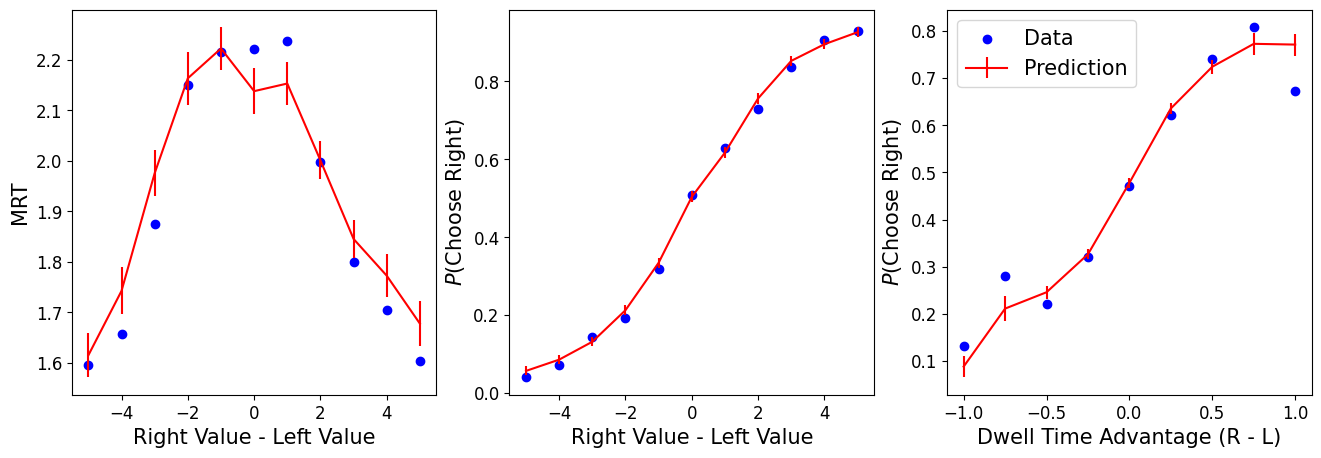

In [12]:
plt.figure(figsize=(16, 5))
plt.subplot(131)
se = pred_bhv.groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(pred_bhv.groupby(by='value_diff')['value_diff'].mean(),
             pred_bhv.groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red')
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel('MRT');

plt.subplot(132)
se = pred_bhv.groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv.groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['choice'].mean()-1, c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(133)
se = pred_bhv.groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(),
             y=pred_bhv.groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, label='Prediction', c='red');
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - L)')['choice'].mean()-1, 
            c='blue', label='Data');
plt.xlabel('Dwell Time Advantage (R - L)');
plt.ylabel(r'$P$(Choose Right)');
plt.legend();

plt.savefig('_plots/kr2010_complete_postpred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');

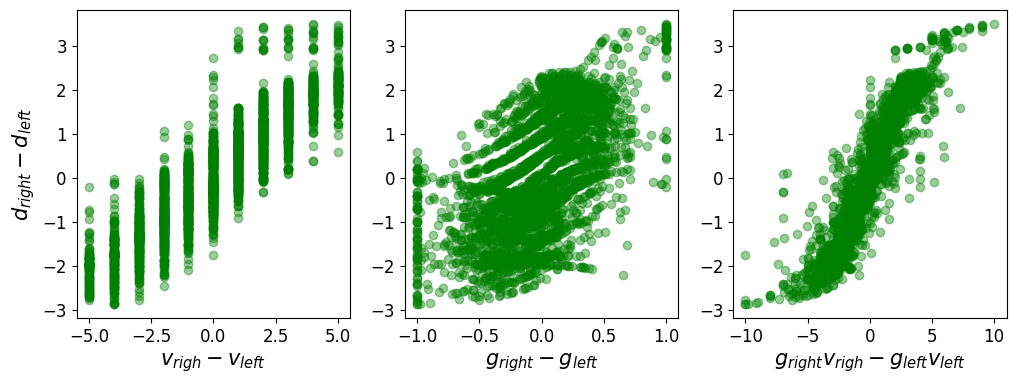

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 0] - X_test[:, 1], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.4, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');
plt.xlabel(r'$v_{righ} - v_{left}$ ');

plt.subplot(132)
plt.scatter(X_test[:, 2] - X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(133)
plt.scatter(X_test[:, 0]*X_test[:, 2] - X_test[:, 1]*X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

plt.savefig('_plots/kr2010_complete_prmspred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');